In [66]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold

In [121]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seqCDR[i] == "_":
            # print("Error: seqCDR contains '_'")
            encoding_list.append(np.zeros(5).reshape(1,5))
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [122]:
class TCR_encode_data(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # encode the CDR3 region
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

        # concatenate the encoded features
        X_features = torch.zeros((len(df),0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)
        
        # discard the duplicate rows, keep the first one
        self.X_features = X_features
        self.y = torch.from_numpy(df["Class"].values)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [110]:
class TCR_autoencoder(nn.Module):
    '''
    The autoencoder for TCR sequence.
    For 230221 dataset, the sequnce length is 41 (20+21), and the input size is 41*5,
    the hidden size is 10. And the output size is 41*5. We apply convolutional neural
    network to encode the sequence, and apply deconvolutional neural network to decode
    the sequence. The activation function for convolutional neural network is ReLU,
    because it is a non-linear function, and it is easy to calculate the gradient.
    For the decoder, we use the same activation function as the encoder.

    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 47)
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 24), based on the formula for conv1d: (W−F+2P)/S+1 = (47-3+2*1)/2+1 = 24
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # (batch_size, 10, 12)
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 6), based on the formula for conv1d: (W−F+2P)/S+1 = (12-3+2*1)/2+1 = 6
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            # (batch_size, 20, 6)
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 6)
            nn.ConvTranspose1d(in_channels=20, out_channels=10, kernel_size=3, stride=3, padding=1),
            # (batch_size, 10, 16), based on the formula for convtranspose1d: (W−1)S−2P+F = (6-1)*3-2*1+3 = 16 
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=10, out_channels=5, kernel_size=4, stride=3, padding=1),
            # (batch_size, 5, 47), based on the formula for convtranspose1d: (W−1)S−2P+F = (16-1)*3-2*1+4 = 47
            nn.Tanh()
        )

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        # print(x.type())
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return encoded, output

In [11]:
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 2

# load the model
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
# model.load_state_dict(torch.load("/DATA/User/wuxinchao/project/pMHC-TCR/ckpt/TCR_autoencoder.pt"))
# model.eval()

# encode the TCR sequence
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)
# TCR_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)
TCR_encode = torch.zeros((0, 20, 6))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    TCR_seq = TCR_seq.view(1, 5, 47).double()
    encoded, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encoded), dim=0)

/tmp/ipykernel_1874379/3053764840.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


In [76]:
class pMHC_TCRDataset(Dataset):
    '''
    The dataset class for pMHC-TCR dataset. 
    The csv file will be read and the TCR sequence will be encoded by the autoencoder or LSTM, as well as the sequence of neoantigen.
    While the HLA type will be one-hot encoded. After that, the encoded sequnce and HLA type will be concatenated as the input of the
    neural network.
    '''
    def __init__(self, file_path, only_CDR3=False, only_experimental=True, TCR_encode=None):
        df, HLA_encode, y  = self.basic_io(file_path, only_CDR3, only_experimental=only_experimental)
        
        if only_CDR3 and TCR_encode is not None:
            X_features = torch.cat((torch.from_numpy(HLA_encode), TCR_encode.view(1,-1)), dim=1)
        elif only_CDR3:
            X_features = torch.from_numpy(HLA_encode)
            for seq in ["Neo_first3", "Neo_last3", "AseqCDR3", "BseqCDR3"]:
                X_features = torch.cat((X_features, torch.from_numpy(df[seq].values)), dim=1)
        else:
            X_features = torch.from_numpy(HLA_encode)
            for seq in ["Neo_first3", "Neo_last3", "AseqCDR_1", "AseqCDR_2", "AseqCDR_3", "BseqCDR_1", "BseqCDR_2", "BseqCDR_3"]:
                X_features = torch.cat((X_features, torch.from_numpy(df[seq].values)), dim=1)

        self.X_features = X_features
        self.y = torch.from_numpy(y)
    
    def basic_io(self, file_path, only_CDR3=True, only_experimental=True):
        # return the dataframe, contain the 
        df = pd.read_csv(file_path, index_col=0)
        # for chain in ["AseqCDR", "BseqCDR"]:
        #     if only_CDR3:
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        #     else:
        #         df[chain+"_1"] = df[chain].str.split("_").str[0]
        #         df[chain+"_2"] = df[chain].str.split("_").str[1]
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        return df, X_HLA_encoded, y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [125]:
# TCR_encode = TCR_encode.view(-1, 20*6)
df = pd.read_csv(file_path, index_col=0)
# for chain in ["AseqCDR", "BseqCDR"]:
#     if only_CDR3:
#         df[chain+"_3"] = df[chain].str.split("_").str[2]
#         df.drop(columns=[chain], inplace=True)
#     else:
#         df[chain+"_1"] = df[chain].str.split("_").str[0]
#         df[chain+"_2"] = df[chain].str.split("_").str[1]
#         df[chain+"_3"] = df[chain].str.split("_").str[2]
#         df.drop(columns=[chain], inplace=True)
df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
# encode the CDR3 region
len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
for chain in ["AseqCDR3", "BseqCDR3"]:
    length = len_map[chain]
    df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
    df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
Error: seqCDR contains '_'
E

In [14]:
TCRData = pMHC_TCRDataset(file_path, only_TCR_seq=True, only_experimental=True, TCR_encode=TCR_encode)

In [15]:
class pMHC_TCR_model(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size=16, 
                 batch_size=32, 
                 num_layers=2, 
                 device="cpu", 
                 use_whole_data=False) -> None:
        super(pMHC_TCR_model, self).__init__()
        if use_whole_data:
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        # self.label = nn.Linear(hidden_size, 1)
        self.linear_layer = nn.Sequential(
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), int(hidden_size/4)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/4), int(hidden_size/8)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/8), 1),
        )

    def forward(self, input):
        if self.batch_size == 0:
            self.batch_size = input.shape[0]
            x = input.float()
            h_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
            # pred = self.label(output[-1])
            pred = self.linear_layer(output[-1])
        else:
            x = input.view(-1, self.batch_size, self.input_size).float()
            h_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            output, (hn, cn) = self.lstm(x, (h_0, c_0))
            # pred = self.label(output[-1])
            pred = self.linear_layer(output[-1])
        return pred

In [17]:
def train(fold, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, target.shape)
        output = output.to(torch.float32)
        target = target.to(torch.float32).view(-1, 1)
        # print(output.shape, target.shape)
        loss = nn.CrossEntropyLoss()(output.view(1,-1), target.view(1,-1))
        train_loss += loss.item() / len(train_loader.dataset)  # sum up batch loss
        pred = output.sigmoid().round()
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                fold, epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(train_loader.dataset)))
    # return the average loss
    # print(f"The batch size is {model.batch_size}")
    return train_loss, correct / len(train_loader.dataset)

def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).to(torch.float32)
            target = target.to(torch.float32).view(-1, 1)
            test_loss += nn.CrossEntropyLoss()(output.reshape(1,-1), target.reshape(1,-1)).item()  # sum up loss
            # print(test_loss)
            pred = output.sigmoid().round()
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f"Test set for fold{fold}: Average Loss: \
          {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} \
          ({100. * correct / len(test_loader.dataset):.0f}%)")
    # print(f"The length of test_loader is {len(test_loader)}")
    return test_loss, correct / len(test_loader.dataset)

Using cuda:0 for training
-------------------Fold 0-------------------


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

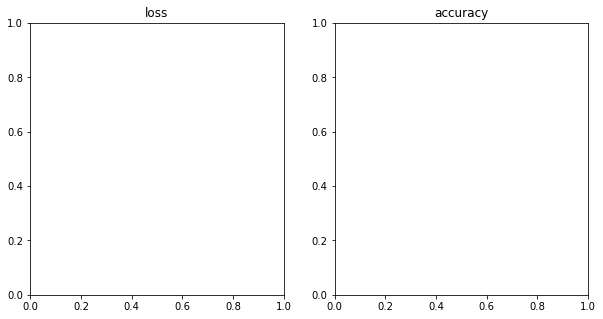

In [20]:
# Training 
batch_size = 32
seq_length = 6
folds = 5
repeats = 12
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} for training")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = pMHC_TCR_model(input_size=122, hidden_size=16, batch_size=batch_size, num_layers=2, device=device, use_whole_data=False).to(device)
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
weights = torch.FloatTensor([5,6])
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=train_subsampler, drop_last=True)
        test_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=test_subsampler, drop_last=True)
    
    # print(f"The length of train_loader is {len(train_loader)}") # 34
    # print(f"The length of test_loader is {len(test_loader)}") # 8
    # print(f"The length of train_dataset is {len(train_loader.dataset)}")
        
    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_loader, optimizer, epoch)
        test_losses, test_correct = test(fold, model, device, test_loader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        train_accuracy_history.append(train_correct)
        test_accuracy_history.append(test_correct)
    ax[0].plot(train_losses_history, "r*--" ,label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, "bs--", label=f"test loss fold{fold}")
    ax[1].plot(train_accuracy_history, "g^--", label=f"train accuracy fold{fold}")
    ax[1].plot(test_accuracy_history, "yo--", label=f"test accuracy fold{fold}")
ax[0].legend()
ax[1].legend()
# put the legend out of the figure, and adjust the position, prevent the figure from being covered
# ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save the figure
fig.savefig("/DATA/User/wuxinchao/project/pMHC-TCR/result/pMHC_without_em_with_encoder_loss_accuracy.png")

After encoding, the features are concatanated and used to predict the binding affinity of pMHC-TCR model.

In [19]:
class pMHC_TCR_pred(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        super(pMHC_TCR_pred, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        # use the encoded features to predict the binding affinity through MLP
        self.Linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        x = self.Linear_layer(x)
        return x

In [70]:
class LSTM_encode(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        self.input_size = input_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        x = x.view(self.batch_size, self.seq_length, self.input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out[:, -1, :] # return the last hidden state

In [124]:
# file_path = "/home/wuxinchao/data/project/data/seqData/20230228.csv"
# TCRData = pMHC_TCRDataset(file_path, only_CDR3=True, only_experimental=True)

In [ ]:
TCRData[0][0].shape

In [84]:
df = pd.read_csv(file_path, index_col=0)

In [99]:
# df["AseqCDR3"].value_counts()
# df["AseqCDR3"].str.len().sort_values(axis=0) # find the longest seq
# df.loc[df["AseqCDR3"].str.len() == 83, "AseqCDR3"]

# plt.hist(df["AseqCDR3"].str.len().sort_values(axis=0))
# plt.show()
df = df.loc[df["AseqCDR3"].str.len() < 83, :]

In [100]:
# len_map
df.to_csv("/home/wuxinchao/data/project/data/seqData/20230228.csv")

In [120]:
df.loc[df["AseqCDR3"].str.contains("_"),]

,Class,HLA,AseqCDR3,BseqCDR3,Neo_first3,Neo_last3
10,positive,HLA-A*02:01,CAASIKAL_NTGKLIF******************************...,CAWTKAGGGETQYF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.01...","[[-0.228, 1.399, -4.76, 0.67, -2.647, 0.26, 0...."
34,positive,HLA-A*02:01,CAASWD*CW_GTSYGKLTF***************************...,CASSITPGANYGYTF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.01...","[[-0.228, 1.399, -4.76, 0.67, -2.647, 0.26, 0...."
53,positive,HLA-A*11:01,CALI*ML_NNRKLIW*******************************...,CASSLQDRARGYTF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.33...","[[-1.337, -0.279, -0.544, 1.242, -1.262, -0.38..."
54,positive,HLA-A*11:01,CAENLTLL*_TGFQKLVF****************************...,CASSLSEGSRGYTF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.33...","[[-1.337, -0.279, -0.544, 1.242, -1.262, -0.38..."
59,positive,HLA-A*11:01,CLVGDES_AGNKLTF*******************************...,CASSLYRGPPQHF,"[[-0.591, -1.302, -0.733, 1.57, -0.146, -0.032...","[[-0.228, 1.399, -4.76, 0.67, -2.647, -0.384, ..."
...,...,...,...,...,...,...
1499,negative,HLA-A*11:01,CAGGCFG_GNQFYF********************************...,CASSLGGSWAQYF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.33...","[[-1.337, -0.279, -0.544, 1.242, -1.262, -0.38..."
1624,negative,HLA-A*11:01,CAENRLRKI_ALGMCCIA****************************...,CSVAGQGLTTEAFF,"[[-0.591, -1.302, -0.733, 1.57, -0.146, -0.032...","[[-0.228, 1.399, -4.76, 0.67, -2.647, -0.384, ..."
1625,negative,HLA-A*11:01,CAENRLRKI_ALGMCCIA****************************...,CSVAGQGLTTEAFF,"[[-0.032, 0.326, 2.213, 0.908, 1.313, -0.032, ...","[[-0.228, 1.399, -4.76, 0.67, -2.647, -0.384, ..."
1626,negative,HLA-A*11:01,CAENRLRKI_ALGMCCIA****************************...,CSVAGQGLTTEAFF,"[[-1.337, -0.279, -0.544, 1.242, -1.262, -1.33...","[[-1.337, -0.279, -0.544, 1.242, -1.262, -0.38..."


In [113]:
df.shape

(38012, 6)